### File descriptions
    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    
    sample_submission.csv - a sample submission file in the correct format.
    
    items.csv - supplemental information about the items/products.

    item_categories.csv  - supplemental information about the items categories.

    shops.csv- supplemental information about the shops.

### Data fields
    
    > ID - an Id that represents a (Shop, Item) tuple within the test set
    
    > shop_id - unique identifier of a shop
    
    > item_id - unique identifier of a product
    
    > item_category_id - unique identifier of item category
    
    > item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    
    > item_price - current price of an item
    
    > date - date in format dd/mm/yyyy
    
    > date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    
    > item_name - name of item
    
    > shop_name - name of shop
    
    > item_category_name - name of item category

# featurizarion



.

### dependency

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb 

import time
from itertools import product
import warnings

import gc

from tqdm import tqdm

# 1. Loading Data

In [14]:
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')


# 2. data cleaning & preparation

### 2.1 data cleaning

observing in some 'item_cnt_day' contain -1 value 

In [23]:
# remove rows contain -1  
sales_train = sales_train[sales_train['item_cnt_day'] != -1]

In [24]:
# warnings.filterwarnings('ignore')

# sns.boxplot(sales_train['item_price'])
# sns.boxplot(sales_train['item_cnt_day'])

- item with more than 51k price there are 2 items are outlier 
 
- items having more than 1000 'iten_cnt_day' are outlier 

In [25]:
# removing outlier 

sales_train = sales_train[sales_train['item_price'] <= 50000]
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]



In [26]:
temp_df = sales_train.copy()
temp_df['date'] = pd.to_datetime(temp_df['date'])

temp_df['month_d'] = temp_df['date'].dt.to_period('M')
temp_df['year'] = temp_df['date'].dt.year

### 2. 2 pre-processing 

**grouping data in monthly format**


AS we need to predict sell of any item on next month so data need to be in month format
where we have item's sales each month which would help to predict next month data


In [27]:
#ques - create df with id, item, item_count_per_month 
df = sales_train.groupby(['shop_id','date_block_num', 'item_id']).agg({ 'item_cnt_day':np.sum}).reset_index()
df.columns = ['shop_id','date_block_num','item_id','item_cnt_month']


In [28]:
# outlier remove

df = df[df.item_cnt_month <1000]

#### creating data set with all possible unique pairs of   "shop - item- date_block_num pair"

In [68]:
%%time
# create dataset
item_ids = items['item_id']
shop_ids = shops['shop_id']
month_d = df['date_block_num'].unique() # list(range(34))


matrix = np.array(list(product(month_d, shop_ids,item_ids)))
matrix =  pd.DataFrame(data, columns = ['date_block_num','shop_id','item_id'])

matrix.sample()

Wall time: 43.7 s


,date_block_num,shop_id,item_id
26781178,20,7,21988


merge() in pandas work as join  
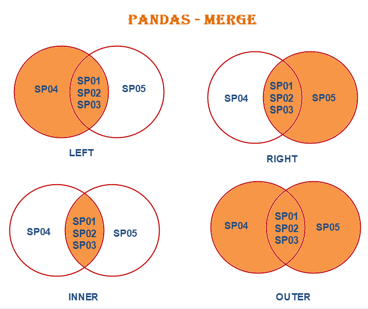

**Merging target value wrt every row** 

In [69]:
# merging target value wrt every row 

matrix = pd.merge(matrix, df, on=['date_block_num','shop_id','item_id'], how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).astype(np.float16))



#### test data

In [85]:

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)


**concatnating 'test' data to main 'matrix'**

In [87]:
%%time

matrix = pd.concat([matrix, test], ignore_index=True ,sort=False, keys=['date_block_num','shop_id','item_id'])
matrix.fillna(0, inplace=True) # 34 month


Wall time: 1.09 s


In [36]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(df.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

# 3. lag feature

**lag feature** - 

A lag features is a fancy name for a variable which contains data from prior time steps. 
If we have time-series data, we can convert it into rows.
Every row contains data about one observation and includes all previous occurrences of 
that observation.

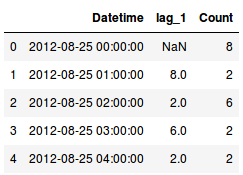

**shift()** - help to create lag feature
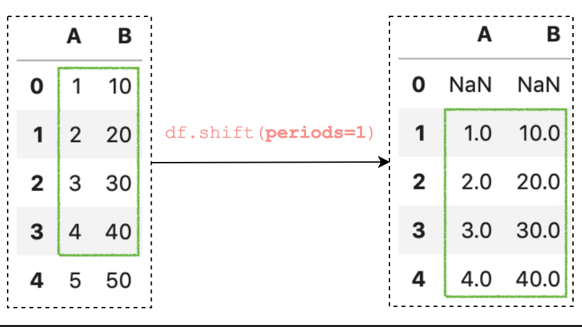


refer - https://www.mikulskibartosz.name/forecasting-time-series-using-lag-features/


In [5]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [7]:
# example - how lag feature work with shift()
series = pd.read_csv('daily-min-temperatures.csv', header=0, index_col=0)
temps = pd.DataFrame(series.values)
dataframe = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-3', 't-2', 't-1', 't+1']
print(dataframe.head(5))

    t-3   t-2   t-1   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN  20.7  17.9
2   NaN  20.7  17.9  18.8
3  20.7  17.9  18.8  14.6
4  17.9  18.8  14.6  15.8


In [43]:
temps.shift(3)

,0
0,NaN
1,NaN
2,NaN
3,20.7
4,17.9
...,...
3645,10.0
3646,12.9
3647,14.6
3648,14.0


# 4. window rolling feature 

<!-- ![image.png](attachment:image.png) -->

in rolling window operation we perform statistic operation on the moving window where
window represent range and statistic operation are mean, median, mode , min, max etc
pandas provide rolling() which provide rolling window calculations gives values at each time stamp.


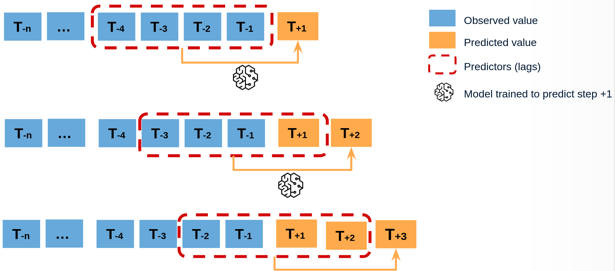
refer:https://www.cienciadedatos.net/images/diagram-recursive-mutistep-forecasting.png


# 5. Featurization

## strategy


- now wrt to each shop and each item and each month , we will create of shop-item-date_block_num pair 
- then add lag features like lag feature, mean encoding
- other feature
- concatinate test data to matrix
- now will dump the matrix in data.pkl


## loading matrix - for faster access


In [5]:
# to encounter memory error
matrix.to_pickle("matrix.pkl")

In [3]:
matrix = pd.read_pickle('matrix.pkl')

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        pdb.set_trace
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

## adding  lag features

- item_cnt_day_lag - 


In [4]:
%%time

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')


Wall time: 3min 15s


In [5]:
matrix.sample()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
6463857,4,51,12387,1.0,0.0,0.0,0.0,0.0,NaN,NaN


## Mean encoded features
here we are adding 3 features - 

- date_avg_item_cnt - previous month avg item_cnt_month - past 1 month data added
- date_item_avg_item_cnt - previous month avg of total sell wrt indivisual item- past "1,2,3,6,12" month data  
- date_shop_avg_item_cnt - previous month avg of all item_cnt_month wrt indivisual shop-  past "1,2,3,6,12" month data



In [6]:
%%time
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost
# previous month avg item_cnt_month for all items

group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Wall time: 1min 13s


In [7]:
matrix.sample()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
30437824,22,52,20584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080078


In [8]:
%%time
# previous month avg of total sell wrt indivisual item  over all shop
# it's tell demand of item in previous month

group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Wall time: 4min 34s


In [9]:
matrix.sample()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12
1956195,1,28,5235,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.099121,0.0,NaN,NaN,NaN,NaN


In [10]:
%%time
# previous month, avg of sell by each indivisual shop  
# it telling- how many avg item sell by the shop in previous month

group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

Wall time: 4min 55s


In [11]:
matrix.sample()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,...,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12
42495992,31,56,18272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.067322,0.070862,0.059448,0.076538,0.135986


**adding category**

In [15]:
# adding category_id 

matrix = pd.merge(matrix, items, on = 'item_id', how = 'left')
matrix = matrix.drop('item_name', axis=1)

In [16]:
%%time
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

Wall time: 2min 6s


In [17]:
matrix.sample()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,...,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,item_category_id,date_cat_avg_item_cnt_lag_1
22026935,16,33,12125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,0.0


## adding date feature - 'month', 'days' 

In [18]:
# adding month
matrix['month'] = matrix['date_block_num'] % 12


# total number of day on that month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [19]:
matrix.sample()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,item_category_id,date_cat_avg_item_cnt_lag_1,month,days
30706903,23,5,1453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033325,0.065247,0.053528,0.06131,0.059906,0.100342,19,0.16333,11,31


# 5. final data preparation 

Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set)

In [20]:
# droping starting 12 month data

matrix = matrix[matrix.date_block_num > 11]

**removing null values**

creating lags feature brings a lot of nulls.

In [21]:
%%time

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

Wall time: 2.44 s


In [22]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'item_category_id',
       'date_cat_avg_item_cnt_lag_1', 'month', 'days'],
      dtype='object')

In [24]:
# saving file as pickle file
matrix.to_pickle('data.pkl')


In [25]:
# relief memory
del matrix
# del df
gc.collect();

In [26]:
data = pd.read_pickle('data.pkl')

In [29]:
data = data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'item_category_id',
       'date_cat_avg_item_cnt_lag_1', 'month', 'days']]

In [31]:
data.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,item_category_id,date_cat_avg_item_cnt_lag_1,month,days
15962400,12,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.13623,...,0.0,0.0,0.0,0.0,0.0,0.251709,40,0.094788,0,31
15962401,12,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.13623,...,0.0,0.0,0.0,0.0,0.0,0.251709,76,0.009460,0,31


**Validation strategy -** 

- 13-33 months for the train.
- 33 month for the validation set and 
- 34 month for the test set, 





In [32]:
# reducing size
data = data[data.date_block_num > 20] 

In [33]:
data.shape

(17506800, 24)

In [35]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [36]:
X_train.shape, X_valid.shape,X_test.shape

((15962400, 23), (1330200, 23), (214200, 23))

In [37]:
# del data
gc.collect()

224

# pending - 6. Model training and evalution
 will be in next uncomming notebook

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor


**linear regression**

In [43]:
%%time
# linear regression

model1 = LinearRegression()
model1 = model1.fit(X_train,Y_train)

y_pred_cv = model1.predict(X_valid)

rmse = mean_squared_error(Y_valid,y_pred_cv)
rmse

Wall time: 15.8 s


0.9990554518314214

RMSE score is - 0.9990554518314214

**Decision tree**

In [130]:
%%time
# decision tree - without hyperparameter tuning

model2 = GradientBoostingRegressor(max_depth=6)
model2.fit(X_train,Y_train)

y_pred_cv3 = model2.predict(X_valid)

rmse = mean_squared_error(Y_valid,y_pred_cv3)
rmse

Wall time: 2h 6min 29s


GradientBoostingRegressor(max_depth=6)

RMSE score is - 2.9738117614808166

**XGBregressor**

In [39]:
%%time
# reference - https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

from xgboost import XGBRegressor

model = XGBRegressor(
    max_depth=8,
    n_estimators=100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit( X_train,Y_train, eval_metric="rmse", eval_set=[(X_valid, Y_valid)], verbose=False, early_stopping_rounds = 10)
    

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Wall time: 3min 38s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=300,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [40]:
y_pred_cv_2 = model.predict(X_valid)

rmse = mean_squared_error(Y_valid,y_pred_cv_2)
rmse

0.88221574

RMSE score is - 0.88221574

In [44]:
model.feature_importances_

array([0.01204341, 0.0301559 , 0.08690146, 0.12408285, 0.06355309,
       0.02416816, 0.016651  , 0.02308651, 0.00640875, 0.01461126,
       0.01237656, 0.0127309 , 0.02779954, 0.04146992, 0.12106174,
       0.05175426, 0.02807903, 0.02430597, 0.0490721 , 0.15036346,
       0.0435944 , 0.02616561, 0.00956406], dtype=float32)

In [41]:
model.feature_names_in_

array(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'item_category_id',
       'date_cat_avg_item_cnt_lag_1', 'month', 'days'], dtype='<U29')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

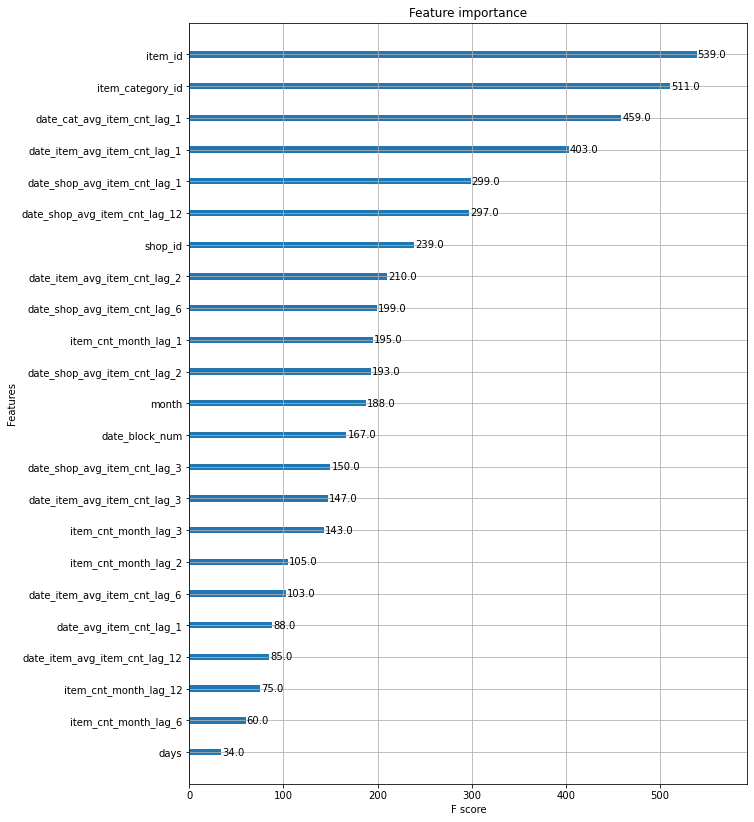

In [42]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)



plot_features(model, (10,14))

In [38]:
# # custom 
# plt.figure(figsize=(20,6))

# plt.plot(model.feature_names_in_, model.feature_importances_)

# plt.show()

In [39]:
# X_valid[X_valid.shop_id == 1]

...
<!-- 
**rolling window**

in rolling window operation we perform statistic operation on the moving window where
window represent range and statistic operation are mean, median, mode , min, max etc
pandas provide rolling() which provide rolling window calculations gives values at each time stamp.

refer- https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0 -->